In [12]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [11]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1194.2290203562477
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4782.63459043234


Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [13]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

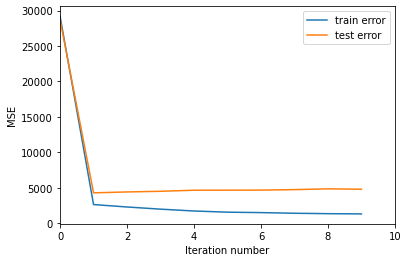

In [14]:
get_error_plot(n_trees, train_errors, test_errors)

In [16]:
depths = [1,3,5,7]
eta = 1
n_trees = 10
coefs = [1] * n_trees
train_errors = []
test_errors = []
for curr_depth in depths:
    _, curr_train_errors, curr_test_errors = gb_fit(n_trees, curr_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errors.append(curr_train_errors[-1])
    test_errors.append(curr_test_errors[-1])

In [17]:
train_errors

[2577.541226350779, 1320.3790105160574, 150.6246923429105, 7.560316671911953]

In [22]:
test_errors

[3912.793548116882, 4799.251075432988, 5458.955253900732, 5512.696337018561]

In [32]:
def get_error_plot_depth(depths, train_err, test_err):
    x = len(depths)
    plt.xlabel('Tree depth')
    plt.ylabel('MSE')
    plt.xlim(0, x)
    plt.xticks(range(x),depths)
    plt.plot(list(range(x)), train_err, label='train error')
    plt.plot(list(range(x)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

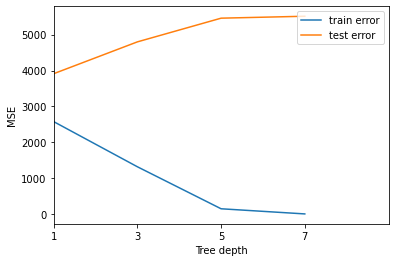

In [33]:
get_error_plot_depth(depths,train_errors,test_errors)

Вывод: увеличение количества деревьев до определённой точки улучшает работу модели, затем приводит к слабому переобучению. Увеличение глубины деревьев может быстро приводить к сильному переобучению, особенно - на простых датасетах.